In [1]:
import pickle
import numpy as np
from scipy.stats import ttest_ind
# import pandas
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
instance_correct = pickle.load(open("results/syntax_attention_correct3.pkl", "rb"))
instance_mispredict = pickle.load(open("results/syntax_attention_misprediction3.pkl", "rb"))

In [12]:
# syntax_type * instance * layer * head * length
# instance_correct

1

In [5]:
print("SyntaxType", "Correct#", "Mispredict#")
print("---------------------------")
for key in instance_correct.keys():
    print(key, len(instance_correct[key]), len(instance_mispredict[key]))

SyntaxType Correct# Mispredict#
---------------------------
annotation 6158 1957
basictype 10642 2074
boolean 2401 561
decimalinteger 5719 1084
identifier 27813 7117
keyword 26711 6923
modifier 26933 6860
operator 23007 5702
separator 27765 7108
null 9137 2270
string 8171 2028
decimalfloatingpoint 154 37


In [13]:
def get_instance_top1_syntax_layer_avg_attribution(syntax_type, instance_correct, instance_mispredict):
    annotation_correct = instance_correct[syntax_type]
    annotation_mispredict = instance_mispredict[syntax_type]
    top_correct_annotation = []

    for instance in annotation_correct:
        instance = np.array(instance)
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []

    for instance in annotation_mispredict:
        instance = np.array(instance)
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))

    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))
    
    avg_correct_annotation = np.mean(coverted_top_correct_annotation, axis=2)
    avg_mispredict_annotation = np.mean(coverted_top_mispredict_annotation, axis=2)
    
    return avg_correct_annotation, avg_mispredict_annotation

In [14]:
for syntax_type in instance_correct.keys():
    if syntax_type != 'booleandecimalinteger':
        print("Syntax type: ", syntax_type)
        avg_correct_annotation, avg_mispredict_annotation = get_instance_top1_syntax_layer_avg_attribution(syntax_type, instance_correct, instance_mispredict)
        # ttest for each layer 
        significantlayer = [] 
        for i in range(12):
            p_value = ttest_ind(avg_correct_annotation[i], avg_mispredict_annotation[i]).pvalue
            if p_value < 0.05:
                significantlayer.append(i)
                
        if len(significantlayer) == 0:
            print("No significant layer")
        else:
            print("Significant layer: ", significantlayer)

Syntax type:  annotation
No significant layer
Syntax type:  basictype
No significant layer
Syntax type:  boolean
No significant layer
Syntax type:  decimalinteger
No significant layer
Syntax type:  identifier
No significant layer
Syntax type:  keyword
No significant layer
Syntax type:  modifier
No significant layer
Syntax type:  operator
No significant layer
Syntax type:  separator
No significant layer
Syntax type:  null
No significant layer
Syntax type:  string
Significant layer:  [0]
Syntax type:  decimalfloatingpoint
No significant layer


In [4]:
syntax_type_list = ['annotation', 'basictype', 'identifier',
                    'keyword', 'modifier', 'operator',
                    'separator', 'string', 'decimalfloatingpoint'] # 'decimalfloatingpoint'

In [5]:
def get_syntax_head_level_attribution_ttest_result(syntax_type, instance_correct, instance_mispredict):
    annotation_correct = instance_correct[syntax_type]
    annotation_mispredict = instance_mispredict[syntax_type]
    top_correct_annotation = []

    for instance in annotation_correct:
        instance = np.array(instance)
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []

    for instance in annotation_mispredict:
        instance = np.array(instance)
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

    p_value_distribution = []
    significant_head_number = 0

    for layer in range(coverted_top_mispredict_annotation.shape[0]):
        layer_attronutions = []
        for head in range(coverted_top_mispredict_annotation.shape[1]):
            p_value = ttest_ind(coverted_top_mispredict_annotation[layer][head], coverted_top_correct_annotation[layer][head]).pvalue
            if p_value < 0.05:
                layer_attronutions.append(0.05)
                significant_head_number += 1
            else:
                layer_attronutions.append(1)
        p_value_distribution.append(layer_attronutions)
        
    return p_value_distribution, significant_head_number

In [6]:
p_value_dict = {}
significant_head_number_dict = {}

for syntax_type in syntax_type_list:
    if syntax_type != 'boolean' or syntax_type != 'decimalfloatingpoint':
        p_value_dict[syntax_type], significant_head_number_dict[syntax_type]= get_syntax_head_level_attribution_ttest_result(syntax_type, instance_correct, instance_mispredict)

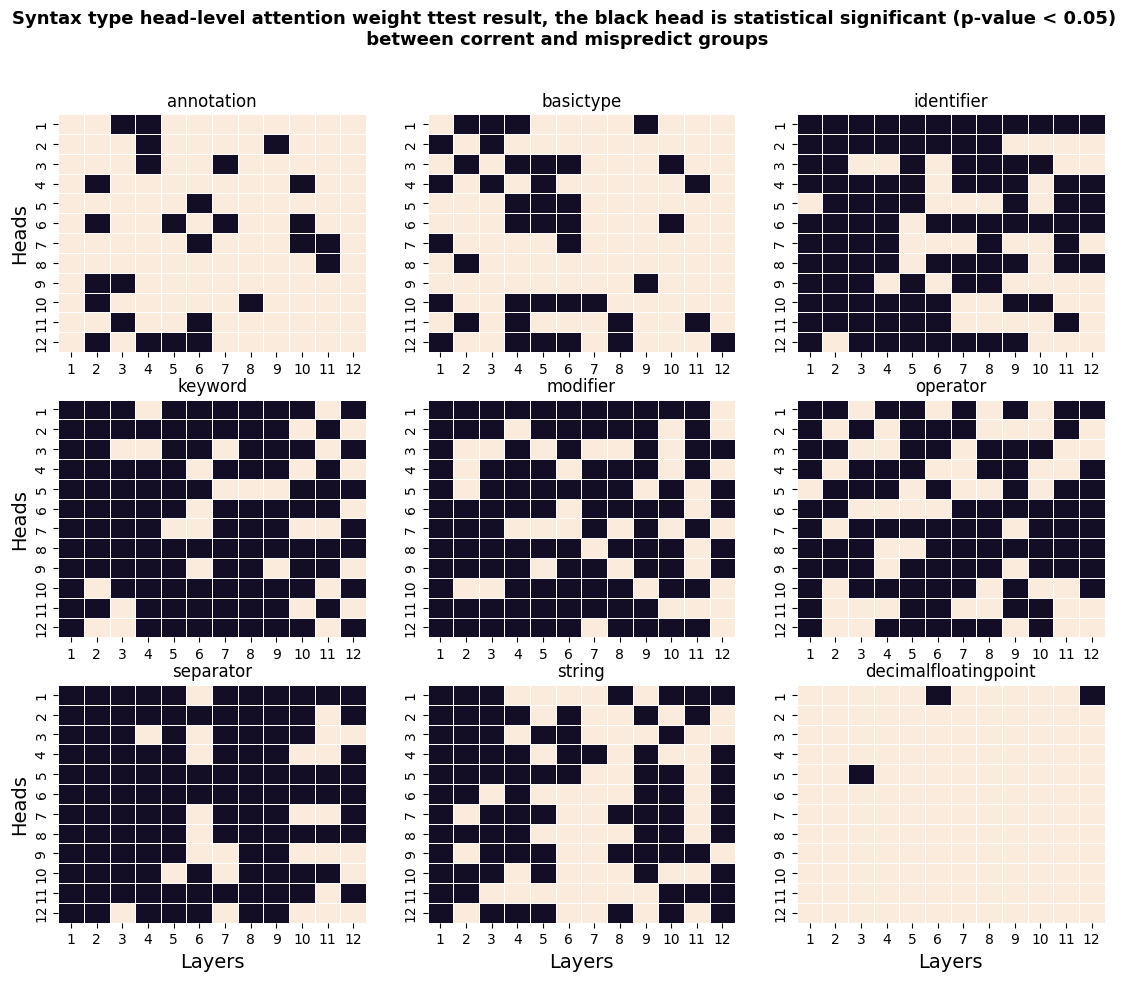

In [12]:

fig, axs = plt.subplots(3, 3)
# set title for whole figure
fig.suptitle('Syntax type head-level attention weight ttest result, the black head is statistical significant (p-value < 0.05)\n between corrent and mispredict groups', fontsize=13, fontweight='bold')

for i in range(3):
    for j in range(3):
        syntax_type = syntax_type_list[i*3+j]
        p_value_distribution = p_value_dict[syntax_type]
        p_value_distribution = np.array(p_value_distribution)
        p_value_distribution = np.transpose(p_value_distribution, (1, 0))
        # axs[i, j].imshow(p_value_distribution, cmap='hot', interpolation='nearest')
        axs[i, j] = sns.heatmap(p_value_distribution, cbar=False, linewidth=0.5, ax=axs[i, j], vmin=0, vmax=1)
        axs[i, j].set_title(syntax_type)
        # add 1 to xticks and yticks
        axs[i, j].set_xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
        axs[i, j].set_yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

# set xlabel for bottom row of subplots
numb = 0
for ax in axs.flat:
    # 
    numb += 1
    if numb > 6:
        ax.set(xlabel='Layers')
        ax.xaxis.label.set_size(14)
# set ylabel for left column of subplots
    if numb == 1 or numb == 4 or numb == 7:
        ax.set(ylabel='Heads')
        ax.yaxis.label.set_size(14)

# change figure size
fig.set_size_inches(13.5, 10.5)
plt.show()

In [8]:
def get_syntax_head_level_attribution_top_heads(syntax_list, instance_correct, instance_mispredict):
    significant_head_record = [[[] for col in range(12)] for row in range(12)]
    
    for syntax_type in syntax_list:
        annotation_correct = instance_correct[syntax_type]
        annotation_mispredict = instance_mispredict[syntax_type]
        
        top_correct_annotation = []
        for instance in annotation_correct:
            instance = np.array(instance)
            top_correct_annotation.append(np.max(instance, axis=2))
            
        top_mispredict_annotation = []
        for instance in annotation_mispredict:
            instance = np.array(instance)
            top_mispredict_annotation.append(np.max(instance, axis=2))
            
        top_mispredict_annotation = np.array(top_mispredict_annotation)
        top_correct_annotation = np.array(top_correct_annotation)

        # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

        coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
        coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

        for layer in range(coverted_top_mispredict_annotation.shape[0]):
            layer_attronutions = []
            for head in range(coverted_top_mispredict_annotation.shape[1]):
                p_value = ttest_ind(coverted_top_mispredict_annotation[layer][head], coverted_top_correct_annotation[layer][head]).pvalue
                if p_value < 0.05:
                    significant_head_record[layer][head].append(syntax_type)
        
    return significant_head_record

In [9]:
significant_head_record = get_syntax_head_level_attribution_top_heads(syntax_type_list, instance_correct, instance_mispredict)

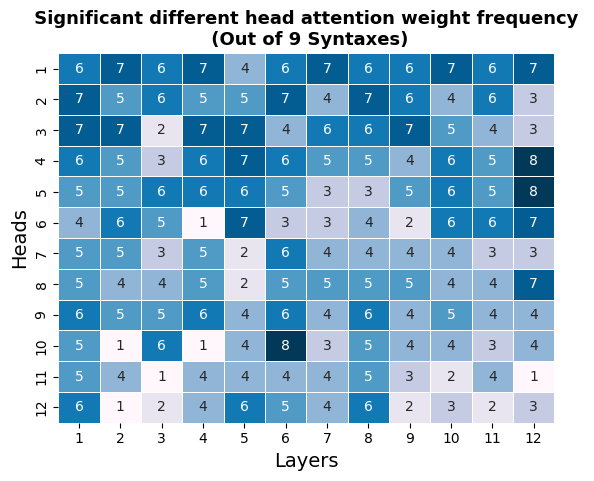

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
head_significant_frequency = [[0 for col in range(12)] for row in range(12)]

for layer in range(len(significant_head_record)):
    for head in range(len(significant_head_record[layer])):
        head_significant_frequency[layer][head] = len(significant_head_record[layer][head])

ax = sns.heatmap(head_significant_frequency, linewidth=0.5, annot=True, cbar=False, fmt='d', cmap='PuBu')
plt.title(' Significant different head attention weight frequency \n (Out of 9 Syntaxes)', fontsize=13, fontweight='bold')
# add one to the x axis
plt.xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
# do same thing for y axis
plt.yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

plt.xlabel('Layers', fontsize=14)
plt.ylabel('Heads', fontsize=14)
plt.show()

###  Only Consider 95% confidence interval data for the analysis

In [30]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [32]:
def get_syntax_head_level_attribution_95P_ttest_result(syntax_type, instance_correct, instance_mispredict):
    annotation_correct = instance_correct[syntax_type]
    annotation_mispredict = instance_mispredict[syntax_type]
    top_correct_annotation = []

    for instance in annotation_correct:
        instance = np.array(instance)
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []

    for instance in annotation_mispredict:
        instance = np.array(instance)
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

    p_value_distribution = []
    significant_head_number = 0

    for layer in range(coverted_top_mispredict_annotation.shape[0]):
        layer_attronutions = []
        for head in range(coverted_top_mispredict_annotation.shape[1]):
            # get 95% confidence interval
            correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head])
            mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
            # get data between the lower and upper bound
            P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
            P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispred_lower and x <= mispred_upper]
            
            p_value = ttest_ind(P95_correct_data, P95_mispred_data).pvalue
            if p_value < 0.05:
                layer_attronutions.append(0.05)
                significant_head_number += 1
            else:
                layer_attronutions.append(1)
        p_value_distribution.append(layer_attronutions)
        
    return p_value_distribution, significant_head_number

In [33]:
p_value_dict = {}
significant_head_number_dict = {}

for syntax_type in syntax_type_list:
    if syntax_type != 'boolean' or syntax_type != 'decimalfloatingpoint':
        p_value_dict[syntax_type], significant_head_number_dict[syntax_type]= get_syntax_head_level_attribution_95P_ttest_result(syntax_type, instance_correct, instance_mispredict)

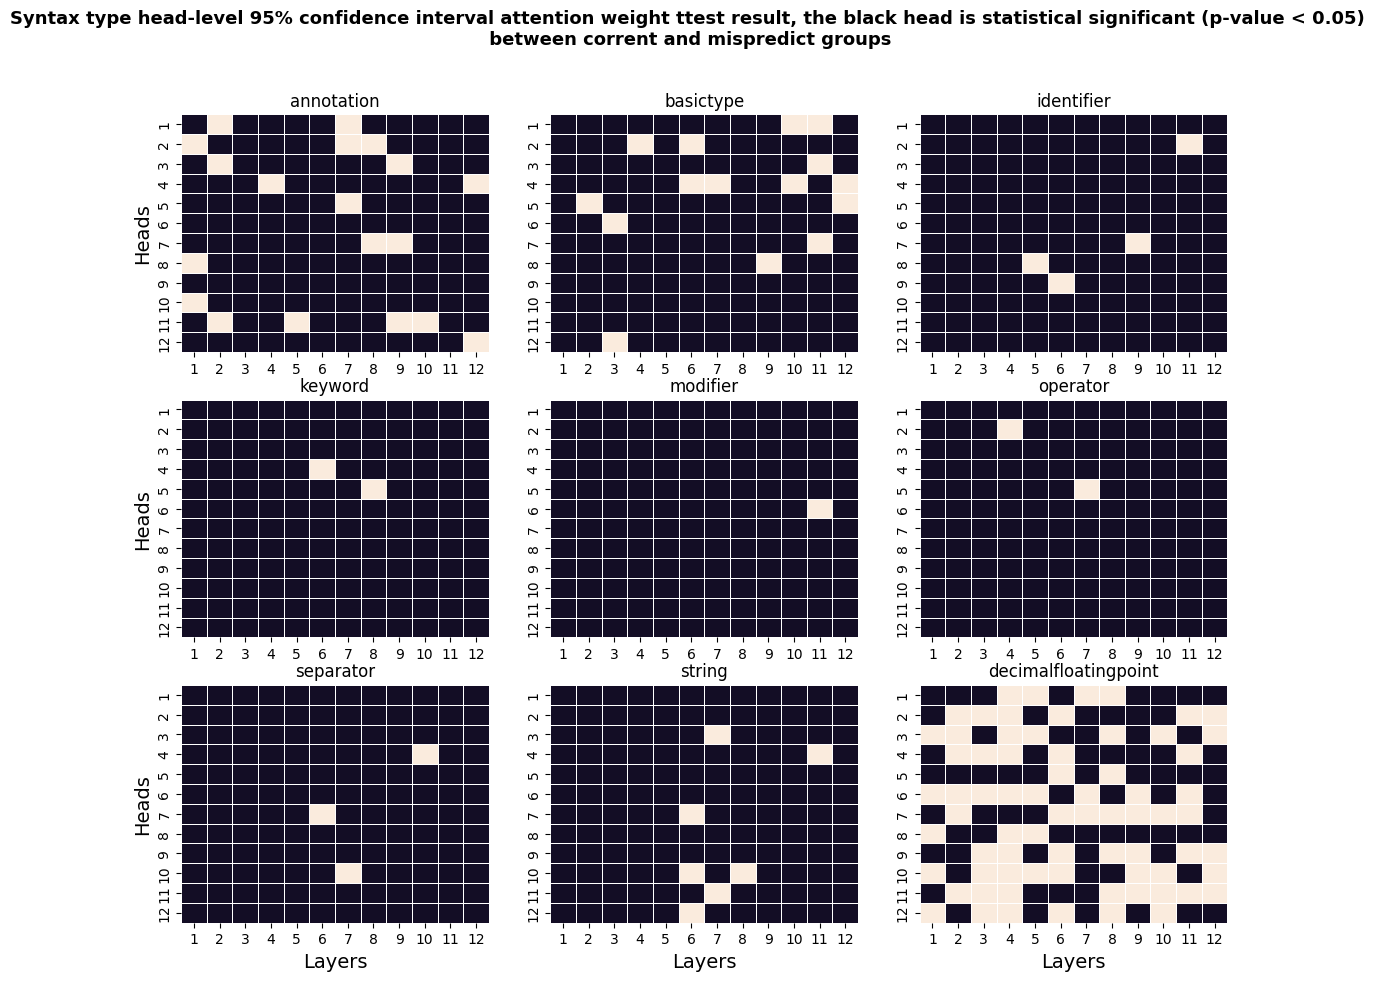

In [39]:
fig, axs = plt.subplots(3, 3)
# set title for whole figure
fig.suptitle('Syntax type head-level 95% confidence interval attention weight ttest result, the black head is statistical significant (p-value < 0.05)\n between corrent and mispredict groups', fontsize=13, fontweight='bold')

for i in range(3):
    for j in range(3):
        syntax_type = syntax_type_list[i*3+j]
        p_value_distribution = p_value_dict[syntax_type]
        p_value_distribution = np.array(p_value_distribution)
        p_value_distribution = np.transpose(p_value_distribution, (1, 0))
        # axs[i, j].imshow(p_value_distribution, cmap='hot', interpolation='nearest')
        axs[i, j] = sns.heatmap(p_value_distribution, cbar=False, linewidth=0.5, ax=axs[i, j], vmin=0, vmax=1)
        axs[i, j].set_title(syntax_type)
        # add 1 to xticks and yticks
        axs[i, j].set_xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
        axs[i, j].set_yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

# set xlabel for bottom row of subplots
numb = 0
for ax in axs.flat:
    # 
    numb += 1
    if numb > 6:
        ax.set(xlabel='Layers')
        ax.xaxis.label.set_size(14)
# set ylabel for left column of subplots
    if numb == 1 or numb == 4 or numb == 7:
        ax.set(ylabel='Heads')
        ax.yaxis.label.set_size(14)

# change figure size
fig.set_size_inches(13.5, 10.5)
plt.show()

In [38]:
def get_syntax_head_level_attribution_95_top_heads(syntax_list, instance_correct, instance_mispredict):
    significant_head_record = [[[] for col in range(12)] for row in range(12)]
    
    for syntax_type in syntax_list:
        annotation_correct = instance_correct[syntax_type]
        annotation_mispredict = instance_mispredict[syntax_type]
        
        top_correct_annotation = []
        for instance in annotation_correct:
            instance = np.array(instance)
            top_correct_annotation.append(np.max(instance, axis=2))
            
        top_mispredict_annotation = []
        for instance in annotation_mispredict:
            instance = np.array(instance)
            top_mispredict_annotation.append(np.max(instance, axis=2))
            
        top_mispredict_annotation = np.array(top_mispredict_annotation)
        top_correct_annotation = np.array(top_correct_annotation)

        # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

        coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
        coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

        for layer in range(coverted_top_mispredict_annotation.shape[0]):
            layer_attronutions = []
            for head in range(coverted_top_mispredict_annotation.shape[1]):
                # get 95% confidence interval
                correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head])
                mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
                # get data between the lower and upper bound
                P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
                P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispred_lower and x <= mispred_upper]
                p_value = ttest_ind(P95_correct_data, P95_mispred_data).pvalue
                if p_value < 0.05:
                    significant_head_record[layer][head].append(syntax_type)
        
    return significant_head_record

In [36]:
significant_head_record = get_syntax_head_level_attribution_95_top_heads(syntax_type_list, instance_correct, instance_mispredict)

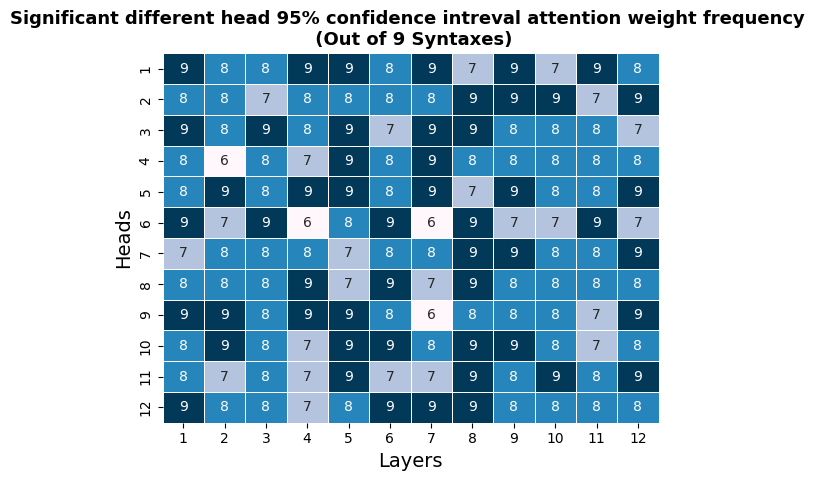

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
head_significant_frequency = [[0 for col in range(12)] for row in range(12)]

for layer in range(len(significant_head_record)):
    for head in range(len(significant_head_record[layer])):
        head_significant_frequency[layer][head] = len(significant_head_record[layer][head])

ax = sns.heatmap(head_significant_frequency, linewidth=0.5, annot=True, cbar=False, fmt='d', cmap='PuBu')
plt.title('Significant different head 95% confidence intreval attention weight frequency \n (Out of 9 Syntaxes)', fontsize=13, fontweight='bold')
# add one to the x axis
plt.xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
# do same thing for y axis
plt.yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

plt.xlabel('Layers', fontsize=14)
plt.ylabel('Heads', fontsize=14)
plt.show()